In [1]:
!pip install --upgrade ultralytics --no-deps
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="dMnFCoF0JyMtpeDmBVam")
project = rf.workspace("sunflower-detection").project("final-1yr0d")
version = project.version(1)
dataset = version.download("coco")
                

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 57.3 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency c


Extracting Dataset Version Zip to Final-1 in coco:: 100%|██████████| 1657/1657 [00:01<00:00, 970.05it/s]


In [2]:
import os, gc, json, shutil, yaml, warnings, random, math, copy
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.manifold import TSNE
import umap.umap_ as umap

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from ultralytics import YOLO


warnings.filterwarnings("ignore")
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42); random.seed(42); np.random.seed(42)
torch.backends.cudnn.benchmark = True
print("Device:", device, "| torch", torch.__version__)

2025-11-02 20:13:13.939496: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762114394.481084      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762114394.609805      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Device: cuda | torch 2.6.0+cu124


In [3]:
import json
import shutil
from pathlib import Path

# Source (read-only)
dataset_dir = Path("/kaggle/working/Final-1")

# Destination (writable)
output_dir = Path("/kaggle/working/sunflower-coco-oneclass")
shutil.copytree(dataset_dir, output_dir, dirs_exist_ok=True)
print(f"✅ Copied dataset to: {output_dir}")

def convert_to_one_class(json_file):
    with open(json_file, "r") as f:
        coco_data = json.load(f)

    # Step 1: Keep only one category
    coco_data["categories"] = [{"id": 1, "name": "Sunflower"}]

    # Step 2: Remap all annotations to category_id = 1
    for ann in coco_data["annotations"]:
        ann["category_id"] = 1

    # Step 3: Save in writable folder
    with open(json_file, "w") as f:
        json.dump(coco_data, f, indent=2)

    print(f"Converted: {json_file}")

# Apply conversion to train/valid/test
for split in ["train", "valid", "test"]:
    json_path = output_dir / split / "_annotations.coco.json"
    if json_path.exists():
        convert_to_one_class(json_path)
    else:
        print(f"⚠ No JSON file found for {split}")

print("\n✅ All done! Update your YAML with:")
print('nc: 1\nnames: ["Sunflower"]')

✅ Copied dataset to: /kaggle/working/sunflower-coco-oneclass
Converted: /kaggle/working/sunflower-coco-oneclass/train/_annotations.coco.json
Converted: /kaggle/working/sunflower-coco-oneclass/valid/_annotations.coco.json
Converted: /kaggle/working/sunflower-coco-oneclass/test/_annotations.coco.json

✅ All done! Update your YAML with:
nc: 1
names: ["Sunflower"]


In [4]:
def get_detect_module(model_module):
    """Return the Detect head (robust across YOLO versions)."""
    try:
        last = model_module.model[-1]
        if "Detect" in last.__class__.__name__:
            return last
    except Exception:
        pass
    cand = None
    for m in model_module.modules():
        if "Detect" in m.__class__.__name__:
            cand = m
    return cand if cand is not None else list(model_module.modules())[-1]

In [5]:
COCO_ROOT     = Path("/kaggle/working/Final-1")  # folder containing train/ and valid/
TRAIN_IMG_DIR = COCO_ROOT / "train"
TRAIN_ANN     = TRAIN_IMG_DIR / "_annotations.coco.json"
VAL_IMG_DIR   = COCO_ROOT / "valid"
VAL_ANN       = VAL_IMG_DIR / "_annotations.coco.json"
WORK          = Path("/kaggle/working/SSL-simclr")  # output directory (can rename)
SSL_W         = WORK / "simclr_backbone.pth" 
WORK.mkdir(parents=True, exist_ok=True)

In [6]:
for split in ["train", "valid", "test"]:
    for sub in ["images", "labels"]:
        (WORK / split / sub).mkdir(parents=True, exist_ok=True)

# Function to convert COCO bbox to YOLO format
def coco2yolo(box, w, h):
    x, y, w_box, h_box = box
    return ((x + w_box/2) / w, (y + h_box/2) / h, w_box / w, h_box / h)

# Convert one split from COCO to YOLO format
def convert(split, img_dir, ann_file, out_dir):
    with open(ann_file, "r") as f:
        coco = json.load(f)

    id2img = {img["id"]: img for img in coco["images"]}
    imgs_o = out_dir / split / "images"
    labs_o = out_dir / split / "labels"

    for ann in coco["annotations"]:
        img = id2img[ann["image_id"]]
        yolo_box = coco2yolo(ann["bbox"], img["width"], img["height"])
        cls = ann["category_id"] - 1  # Class index starts from 0 in YOLO
        label_path = labs_o / f"{Path(img['file_name']).stem}.txt"
        with open(label_path, "a") as f:
            f.write(f"{cls} " + " ".join(f"{v:.6f}" for v in yolo_box) + "\n")

    for img in coco["images"]:
        shutil.copy(img_dir / img["file_name"], imgs_o / img["file_name"])

# ----------------------------------------------------------------------------
# 1. Perform Conversion
# ----------------------------------------------------------------------------
convert("train", TRAIN_IMG_DIR, TRAIN_ANN, WORK)
convert("valid", VAL_IMG_DIR,   VAL_ANN,   WORK)
convert("test",  TRAIN_IMG_DIR, TRAIN_ANN, WORK) 

In [7]:
import yaml

cats  = json.load(open(TRAIN_ANN))["categories"]
names = [c["name"] for c in sorted(cats, key=lambda x: x["id"])]
data_cfg = {
    "path":  str(WORK),
    "train": "train/images",
    "val":   "valid/images",
    "test":  "test/images",
    "nc":    len(names),
    "names": names
}
DATA = WORK / "sunflower-Panicle.yaml"
(DATA).write_text(yaml.dump(data_cfg))

147

In [8]:
class TwoView(Dataset):
    SUPP = ('*.jpg','*.JPG','*.jpeg','*.JPEG','*.png','*.PNG','*.bmp','*.BMP','*.webp','*.WEBP')
    def __init__(self, roots, tfm):
        self.files=[]
        for r in roots:
            pr=Path(r)
            for p in self.SUPP:
                self.files.extend(pr.rglob(p))
        if not self.files: raise RuntimeError(f"No images found under {roots}")
        self.tfm=tfm
    def __len__(self): return len(self.files)
    def __getitem__(self,idx):
        img=Image.open(self.files[idx]).convert("RGB")
        return self.tfm(img), self.tfm(img)

augment = transforms.Compose([
    transforms.RandomResizedCrop(160, scale=(0.2, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.3,0.3,0.3,0.1),
    transforms.RandomGrayscale(0.2),
    transforms.GaussianBlur(kernel_size=7, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
])

In [9]:
def byol_loss(p, z):
    p = F.normalize(p, dim=1)
    z = F.normalize(z, dim=1)
    return 2 - 2*(p*z).sum(dim=1).mean()

class DetectInputHook:
    def __init__(self, detect_module):
        self.handle = detect_module.register_forward_pre_hook(self.hook)
        self.feats = None
    def hook(self, module, inputs):
        # inputs is a tuple with a single item: a list/tuple of FPN maps [P3,P4,P5]
        self.feats = list(inputs[0])  # keep tensors with grad for online
        return None
    def close(self):
        self.handle.remove()

def global_pool_concat(feats):
    pooled = [F.adaptive_avg_pool2d(f, 1).flatten(1) for f in feats]
    return torch.cat(pooled, dim=1)

In [10]:
MODEL = "yolo12s.pt"     # YOLOv12 nano config
SSL_EPOCHS, SSL_BATCH =100,16 # EPOCHS and BATCH SIZE
m0 = 0.996

if SSL_W.exists():
    print("simclr backbone cached – skipping pre-train")
else:
    print("simclr pre-training (1 epoch, hook-based, YOLOv12) …")

    # full models (we'll read neck features via hook)
    online_full = YOLO(MODEL).model.to(device)
    target_full = YOLO(MODEL).model.to(device)
    target_full.load_state_dict(online_full.state_dict())
    for p in target_full.parameters(): p.requires_grad=False

    # register hooks on Detect heads to capture P3,P4,P5
    online_hook = DetectInputHook(get_detect_module(online_full))
    target_hook = DetectInputHook(get_detect_module(target_full))

    # infer feature dim
    with torch.no_grad():
        dmy = torch.zeros(1,3,160,160,device=device)
        _ = online_full(dmy)                # run forward to populate hook
        feat_dim = global_pool_concat(online_hook.feats).shape[1]
    print("Backbone feature dim:", feat_dim)

    def projector():
        return nn.Sequential(
            nn.Linear(feat_dim,512,bias=False),
            nn.BatchNorm1d(512), nn.ReLU(inplace=True),
            nn.Linear(512,256,bias=False)
        )
    def predictor():
        return nn.Sequential(
            nn.Linear(256,512,bias=False),
            nn.BatchNorm1d(512), nn.ReLU(inplace=True),
            nn.Linear(512,256,bias=False)
        )

    proj_o, proj_t = projector().to(device), projector().to(device)
    pred_o         = predictor().to(device)
    proj_t.load_state_dict(proj_o.state_dict())
    for p in proj_t.parameters(): p.requires_grad=False

    # optimize only online_full (backbone+neck) + projector/predictor
    opt = torch.optim.AdamW(
        list(online_full.parameters()) + list(proj_o.parameters()) + list(pred_o.parameters()),
        lr=1e-3, weight_decay=1e-4
    )
    scaler = torch.amp.GradScaler(enabled=(device=="cuda"))

    @torch.no_grad()
    def ema_update(src, dst, m):
        for ps, pd in zip(src.parameters(), dst.parameters()):
            pd.data.mul_(m).add_(ps.data, alpha=1-m)

    def momentum_scheduled(step, total_steps, base=m0):
        if total_steps <= 1: return 1.0
        tau = step / (total_steps - 1)
        return 1.0 - (1.0 - base) * (0.5 * (1.0 + math.cos(math.pi * tau)))

    ds = TwoView([WORK/"train"/"images", WORK/"valid"/"images"], augment)
    dl = DataLoader(ds, batch_size=SSL_BATCH, shuffle=True,
                    num_workers=0, pin_memory=False, drop_last=True)

    total_steps = max(1, SSL_EPOCHS * len(dl))
    step = 0
    for ep in range(SSL_EPOCHS):
        online_full.train(); proj_o.train(); pred_o.train()
        running=0.0
        pbar = tqdm(dl, desc=f"simclr {ep+1}/{SSL_EPOCHS}", leave=False)

        for v1,v2 in pbar:
            v1,v2 = v1.to(device, non_blocking=True), v2.to(device, non_blocking=True)
            m_cur = momentum_scheduled(step, total_steps)

            with torch.autocast(device_type='cuda', enabled=(device=="cuda")):
                # online encodes (features captured by hook)
                _ = online_full(v1)
                h1 = global_pool_concat(online_hook.feats)
                _ = online_full(v2)
                h2 = global_pool_concat(online_hook.feats)

                z1_o = proj_o(h1); z2_o = proj_o(h2)
                p1   = pred_o(z1_o); p2 = pred_o(z2_o)

                # target encodes (EMA, no grad)
                with torch.no_grad():
                    ema_update(online_full, target_full, m_cur)
                    ema_update(proj_o, proj_t, m_cur)
                    _ = target_full(v1)
                    h1_t = global_pool_concat(target_hook.feats)
                    _ = target_full(v2)
                    h2_t = global_pool_concat(target_hook.feats)
                    z1_t = proj_t(h1_t); z2_t = proj_t(h2_t)

                loss = byol_loss(p1, z2_t) + byol_loss(p2, z1_t)

            scaler.scale(loss).backward()
            scaler.step(opt); scaler.update(); opt.zero_grad(set_to_none=True)
            running += loss.item()
            step += 1
            pbar.set_postfix(loss=f"{loss.item():.4f}", m=f"{m_cur:.4f}")

        print(f"Epoch {ep+1}/{SSL_EPOCHS} simclr loss={running/len(dl):.4f}")

    # save ONLY backbone+neck weights (exclude Detect head)
    torch.save({k:v for k,v in online_full.state_dict().items()
                if not k.startswith('model.%d' % (len(online_full.model)-1))}, SSL_W)

    online_hook.close(); target_hook.close()
    del online_full, target_full, proj_o, proj_t, pred_o, dl, ds
    gc.collect(); 
    if device=="cuda": torch.cuda.empty_cache()
    print("✓ Saved SSL backbone weights →", SSL_W)

simclr pre-training (1 epoch, hook-based, YOLOv12) …
Backbone feature dim: 896


simclr 1/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 1/100 simclr loss=1.5557


simclr 2/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 2/100 simclr loss=1.4582


simclr 3/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 3/100 simclr loss=1.4271


simclr 4/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 4/100 simclr loss=1.4208


simclr 5/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 5/100 simclr loss=1.4122


simclr 6/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 6/100 simclr loss=1.4185


simclr 7/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 7/100 simclr loss=1.3730


simclr 8/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 8/100 simclr loss=1.3339


simclr 9/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 9/100 simclr loss=1.3083


simclr 10/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 10/100 simclr loss=1.2962


simclr 11/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 11/100 simclr loss=1.2321


simclr 12/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 12/100 simclr loss=1.2064


simclr 13/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 13/100 simclr loss=1.2419


simclr 14/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 14/100 simclr loss=1.2531


simclr 15/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 15/100 simclr loss=1.2592


simclr 16/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 16/100 simclr loss=1.1970


simclr 17/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 17/100 simclr loss=1.2285


simclr 18/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 18/100 simclr loss=1.1588


simclr 19/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 19/100 simclr loss=1.1527


simclr 20/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 20/100 simclr loss=1.1606


simclr 21/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 21/100 simclr loss=1.1522


simclr 22/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 22/100 simclr loss=1.1342


simclr 23/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 23/100 simclr loss=1.1264


simclr 24/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 24/100 simclr loss=1.0817


simclr 25/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 25/100 simclr loss=1.0526


simclr 26/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 26/100 simclr loss=1.0622


simclr 27/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 27/100 simclr loss=1.0459


simclr 28/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 28/100 simclr loss=1.0708


simclr 29/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 29/100 simclr loss=1.0435


simclr 30/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 30/100 simclr loss=1.0991


simclr 31/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 31/100 simclr loss=1.0904


simclr 32/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 32/100 simclr loss=1.0726


simclr 33/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 33/100 simclr loss=1.0758


simclr 34/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 34/100 simclr loss=1.0793


simclr 35/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 35/100 simclr loss=1.0997


simclr 36/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 36/100 simclr loss=1.0605


simclr 37/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 37/100 simclr loss=1.0578


simclr 38/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 38/100 simclr loss=1.0668


simclr 39/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 39/100 simclr loss=1.0597


simclr 40/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 40/100 simclr loss=1.0714


simclr 41/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 41/100 simclr loss=1.0785


simclr 42/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 42/100 simclr loss=1.0812


simclr 43/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 43/100 simclr loss=1.0783


simclr 44/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 44/100 simclr loss=1.0852


simclr 45/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 45/100 simclr loss=1.0816


simclr 46/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 46/100 simclr loss=1.0780


simclr 47/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 47/100 simclr loss=1.0991


simclr 48/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 48/100 simclr loss=1.0850


simclr 49/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 49/100 simclr loss=1.0923


simclr 50/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 50/100 simclr loss=1.1482


simclr 51/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 51/100 simclr loss=1.1372


simclr 52/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 52/100 simclr loss=1.0929


simclr 53/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 53/100 simclr loss=1.1227


simclr 54/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 54/100 simclr loss=1.1615


simclr 55/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 55/100 simclr loss=1.1130


simclr 56/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 56/100 simclr loss=1.1186


simclr 57/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 57/100 simclr loss=1.1262


simclr 58/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 58/100 simclr loss=1.1568


simclr 59/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 59/100 simclr loss=1.1184


simclr 60/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 60/100 simclr loss=1.1451


simclr 61/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 61/100 simclr loss=1.1614


simclr 62/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 62/100 simclr loss=1.1437


simclr 63/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 63/100 simclr loss=1.1263


simclr 64/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 64/100 simclr loss=1.1385


simclr 65/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 65/100 simclr loss=1.1462


simclr 66/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 66/100 simclr loss=1.1439


simclr 67/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 67/100 simclr loss=1.1350


simclr 68/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 68/100 simclr loss=1.1471


simclr 69/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 69/100 simclr loss=1.1374


simclr 70/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 70/100 simclr loss=1.1675


simclr 71/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 71/100 simclr loss=1.1466


simclr 72/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 72/100 simclr loss=1.1499


simclr 73/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 73/100 simclr loss=1.1844


simclr 74/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 74/100 simclr loss=1.1468


simclr 75/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 75/100 simclr loss=1.1290


simclr 76/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 76/100 simclr loss=1.1408


simclr 77/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 77/100 simclr loss=1.1665


simclr 78/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 78/100 simclr loss=1.1501


simclr 79/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 79/100 simclr loss=1.1499


simclr 80/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 80/100 simclr loss=1.1491


simclr 81/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 81/100 simclr loss=1.1412


simclr 82/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 82/100 simclr loss=1.1228


simclr 83/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 83/100 simclr loss=1.1438


simclr 84/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 84/100 simclr loss=1.1524


simclr 85/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 85/100 simclr loss=1.1519


simclr 86/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 86/100 simclr loss=1.1410


simclr 87/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 87/100 simclr loss=1.1290


simclr 88/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 88/100 simclr loss=1.1394


simclr 89/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 89/100 simclr loss=1.1262


simclr 90/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 90/100 simclr loss=1.1495


simclr 91/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 91/100 simclr loss=1.1319


simclr 92/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 92/100 simclr loss=1.1142


simclr 93/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 93/100 simclr loss=1.1521


simclr 94/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 94/100 simclr loss=1.1407


simclr 95/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 95/100 simclr loss=1.1446


simclr 96/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 96/100 simclr loss=1.1373


simclr 97/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 97/100 simclr loss=1.1493


simclr 98/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 98/100 simclr loss=1.1225


simclr 99/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 99/100 simclr loss=1.1117


simclr 100/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 100/100 simclr loss=1.1263
✓ Saved SSL backbone weights → /kaggle/working/SSL-simclr/simclr_backbone.pth


➤ Loading simclr feature extractor …
➤ Extracting features …


Extract train:   0%|          | 0/21 [00:00<?, ?it/s]

Extract val:   0%|          | 0/3 [00:00<?, ?it/s]


simclr k-NN evaluation …
k-NN accuracy (val): 1.0000


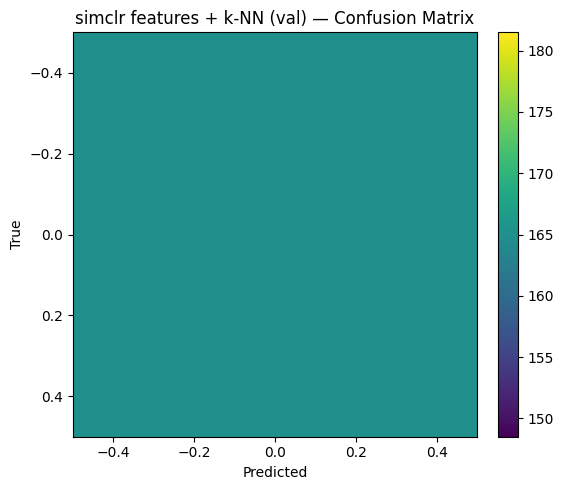

➤ Running PCA …
PCA 2D explained variance: 28.03%


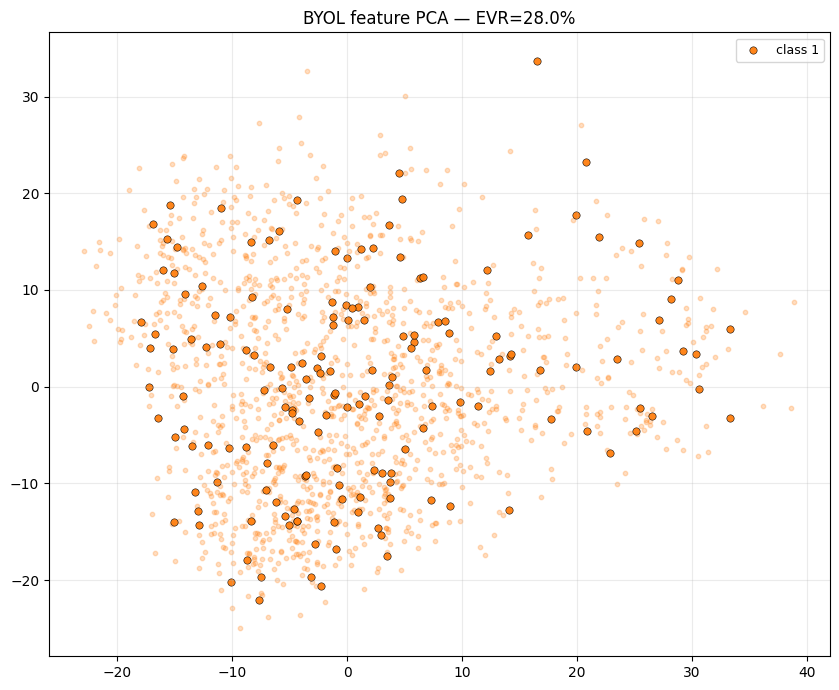

➤ Running t-SNE …


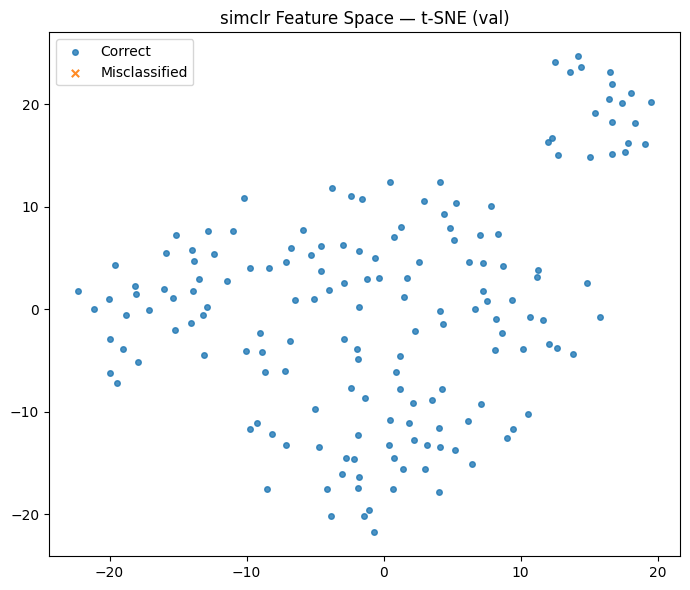

In [11]:
PLOTS  = WORK / "plots"
PLOTS.mkdir(parents=True, exist_ok=True)

# --- HELPERS ---
def imread_rgb(path: Path):
    return Image.open(path).convert("RGB")

def yolo_label_for_image(label_file: Path):
    if not label_file.exists():
        return None
    ids=[]
    with open(label_file) as f:
        for line in f:
            parts=line.strip().split()
            if parts:
                try: ids.append(int(parts[0]))
                except: pass
    return max(ids, key=ids.count) if ids else None

def list_images_and_labels(split_dir: Path):
    xs, ys = [], []
    images = sorted((split_dir/"images").glob("*.*"))
    for img_path in images:
        lb_path = (split_dir/"labels"/(img_path.stem + ".txt"))
        lab = yolo_label_for_image(lb_path)
        if lab is None:
            continue
        xs.append(img_path); ys.append(lab)
    return xs, np.array(ys, dtype=np.int64)

def get_detect_module(model_module):
    try:
        last = model_module.model[-1]
        if "Detect" in last.__class__.__name__:
            return last
    except Exception:
        pass
    cand = None
    for m in model_module.modules():
        if "Detect" in m.__class__.__name__:
            cand = m
    return cand if cand is not None else list(model_module.modules())[-1]

class DetectInputHook:
    def __init__(self, detect_module):
        self.handle = detect_module.register_forward_pre_hook(self.hook)
        self.feats = None
    def hook(self, module, inputs):
        self.feats = list(inputs[0])    # [P3,P4,P5]
        return None
    def close(self): self.handle.remove()

def global_pool_concat(feats):
    pooled = [F.adaptive_avg_pool2d(f, 1).flatten(1) for f in feats]
    return torch.cat(pooled, dim=1)

# --- DATA ---
train_X, train_y = list_images_and_labels(WORK/"train")
val_X,   val_y   = list_images_and_labels(WORK/"valid")
assert len(train_X) and len(val_X), "No labeled images found."

# --- FEATURE EXTRACTION ---
print("➤ Loading simclr feature extractor …")
feat_model = YOLO("yolo12s.pt").model.to(device)
_ = feat_model.load_state_dict(torch.load(SSL_W, map_location="cpu"), strict=False)
feat_hook  = DetectInputHook(get_detect_module(feat_model))
feat_model.eval()

base_tfm = transforms.Compose([transforms.Resize((160,160)), transforms.ToTensor()])

class ImgDataset(Dataset):
    def __init__(self, paths, tfm): self.paths=paths; self.tfm=tfm
    def __len__(self): return len(self.paths)
    def __getitem__(self,i): return self.tfm(imread_rgb(self.paths[i]))

def extract_feats(paths, bs=64, desc="Extract"):
    ds  = ImgDataset(paths, base_tfm)
    dl  = DataLoader(ds, batch_size=bs, shuffle=False, num_workers=0, pin_memory=False)
    feats=[]
    for xb in tqdm(dl, total=len(dl), desc=desc, leave=False):
        xb = xb.to(device, non_blocking=True)
        with torch.no_grad():
            _ = feat_model(xb)
            h  = global_pool_concat(feat_hook.feats)
        feats.append(h.detach().cpu().numpy())
    return np.concatenate(feats, axis=0) if feats else np.zeros((0,1))

print("➤ Extracting features …")
train_F = extract_feats(train_X, bs=64, desc="Extract train")
val_F   = extract_feats(val_X,   bs=64, desc="Extract val")

feat_hook.close()
del feat_model
gc.collect()
if device=="cuda": torch.cuda.empty_cache()

# --- k-NN CLASSIFIER ---
print("\nsimclr k-NN evaluation …")
knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn.fit(train_F, train_y)
val_pred = knn.predict(val_F)
acc = accuracy_score(val_y, val_pred)
print(f"k-NN accuracy (val): {acc:.4f}")

# Confusion matrix
cm = confusion_matrix(val_y, val_pred)
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation="nearest")
plt.title("simclr features + k-NN (val) — Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout()
plt.savefig(PLOTS/"knn_confusion_matrix.png", dpi=160)
plt.show()

# --- STANDARDIZE ---
scaler = StandardScaler(with_mean=True, with_std=True)
train_Fs = scaler.fit_transform(train_F)
val_Fs   = scaler.transform(val_F)

# --- PCA ---
print("➤ Running PCA …")
pca = PCA(n_components=2, random_state=42)
train_P = pca.fit_transform(train_Fs)
val_P   = pca.transform(val_Fs)
evr = pca.explained_variance_ratio_.sum()
print(f"PCA 2D explained variance: {evr*100:.2f}%")

plt.figure(figsize=(8.5,7))
classes = np.unique(np.concatenate([train_y, val_y]))
cmap = plt.get_cmap("tab10")
for c in classes:
    idx = np.where(train_y==c)[0]
    if len(idx):
        plt.scatter(train_P[idx,0], train_P[idx,1], s=10, alpha=0.25, color=cmap(int(c)%10))
for c in classes:
    idx = np.where(val_y==c)[0]
    if len(idx):
        plt.scatter(val_P[idx,0], val_P[idx,1], s=28, alpha=0.95, edgecolors='k', linewidths=0.4,
                    color=cmap(int(c)%10), marker='o', label=f"class {c}")
plt.title(f"BYOL feature PCA — EVR={evr*100:.1f}%")
plt.legend(fontsize=9, ncol=2, frameon=True)
plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.savefig(PLOTS/"pca_train_val.png", dpi=160)
plt.show()

# --- t-SNE ---
if len(val_F) > 10:
    print("➤ Running t-SNE …")
    perplex = min(30, max(5, len(val_F)//10))
    tsne = TSNE(n_components=2, init="pca", learning_rate="auto",
                perplexity=perplex, n_iter=1000, random_state=42)
    Z_tsne = tsne.fit_transform(val_Fs)
    mistakes = (val_pred != val_y)
    plt.figure(figsize=(7,6))
    plt.scatter(Z_tsne[~mistakes,0], Z_tsne[~mistakes,1], s=16, label="Correct", alpha=0.8)
    plt.scatter(Z_tsne[mistakes,0],   Z_tsne[mistakes,1],   s=28, marker="x", label="Misclassified", alpha=0.9)
    plt.title("simclr Feature Space — t-SNE (val)")
    plt.legend(); plt.tight_layout()
    plt.savefig(PLOTS/"tsne_val.png", dpi=160)
    plt.show()

In [12]:
print("\n Fine-tuning YOLOv12-s (1 epoch) …")
det = YOLO(MODEL)  # nano to match SSL shapes
# load into all-but-Detect
sd = torch.load(SSL_W, map_location="cpu")
det.model.load_state_dict(sd, strict=False)

det.train(
    data=str(DATA),
    epochs=100,                # ← set to 1 epoch
    imgsz=640,
    batch=8,
    project=str(WORK),
    save = True,
    name="simclr_yolo12s",
    device=0 if device=="cuda" else None,
    verbose=True
)


 Fine-tuning YOLOv12-s (1 epoch) …
Ultralytics 8.3.223 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/SSL-simclr/sunflower-Panicle.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=simclr_yolo12s, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overl

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d1d68735650>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

Available columns: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


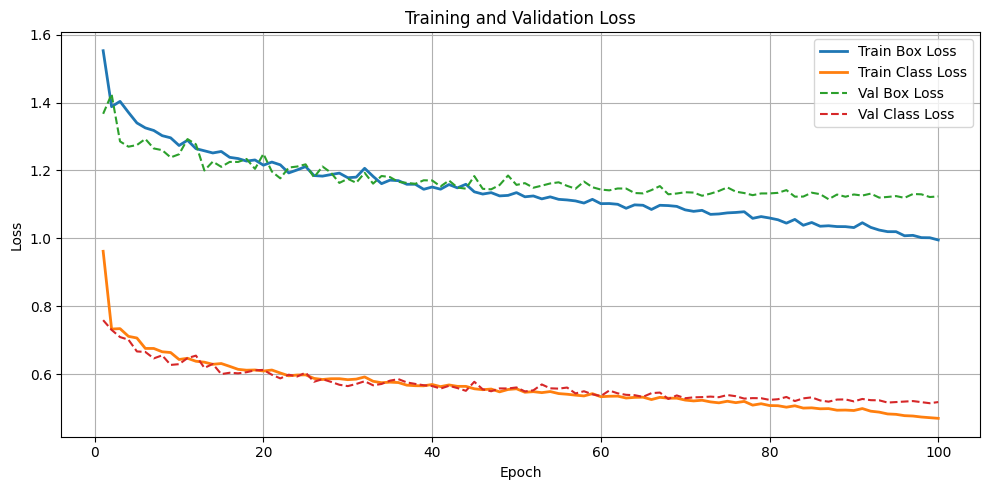

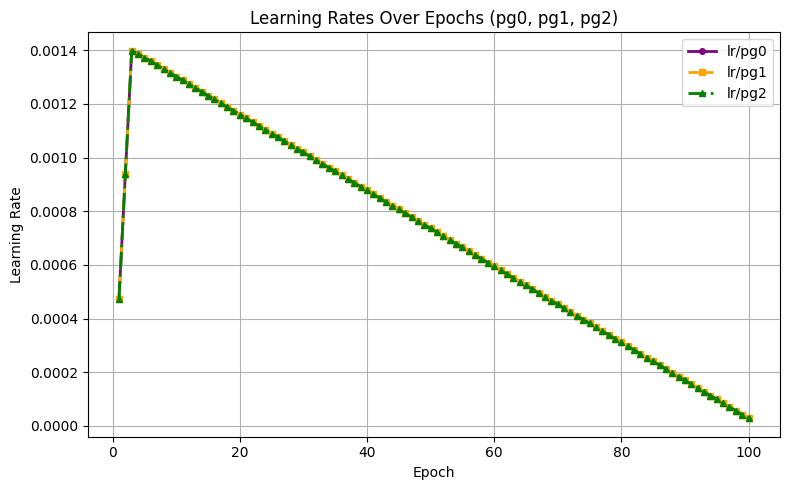

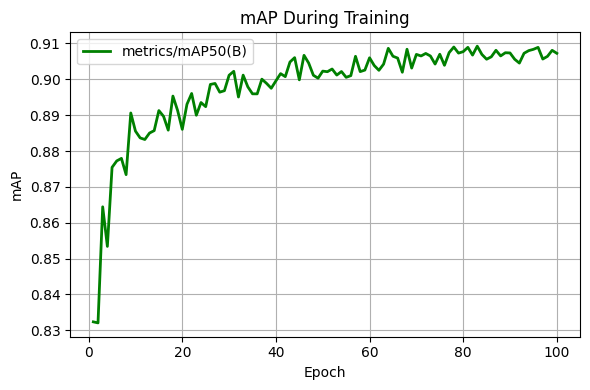

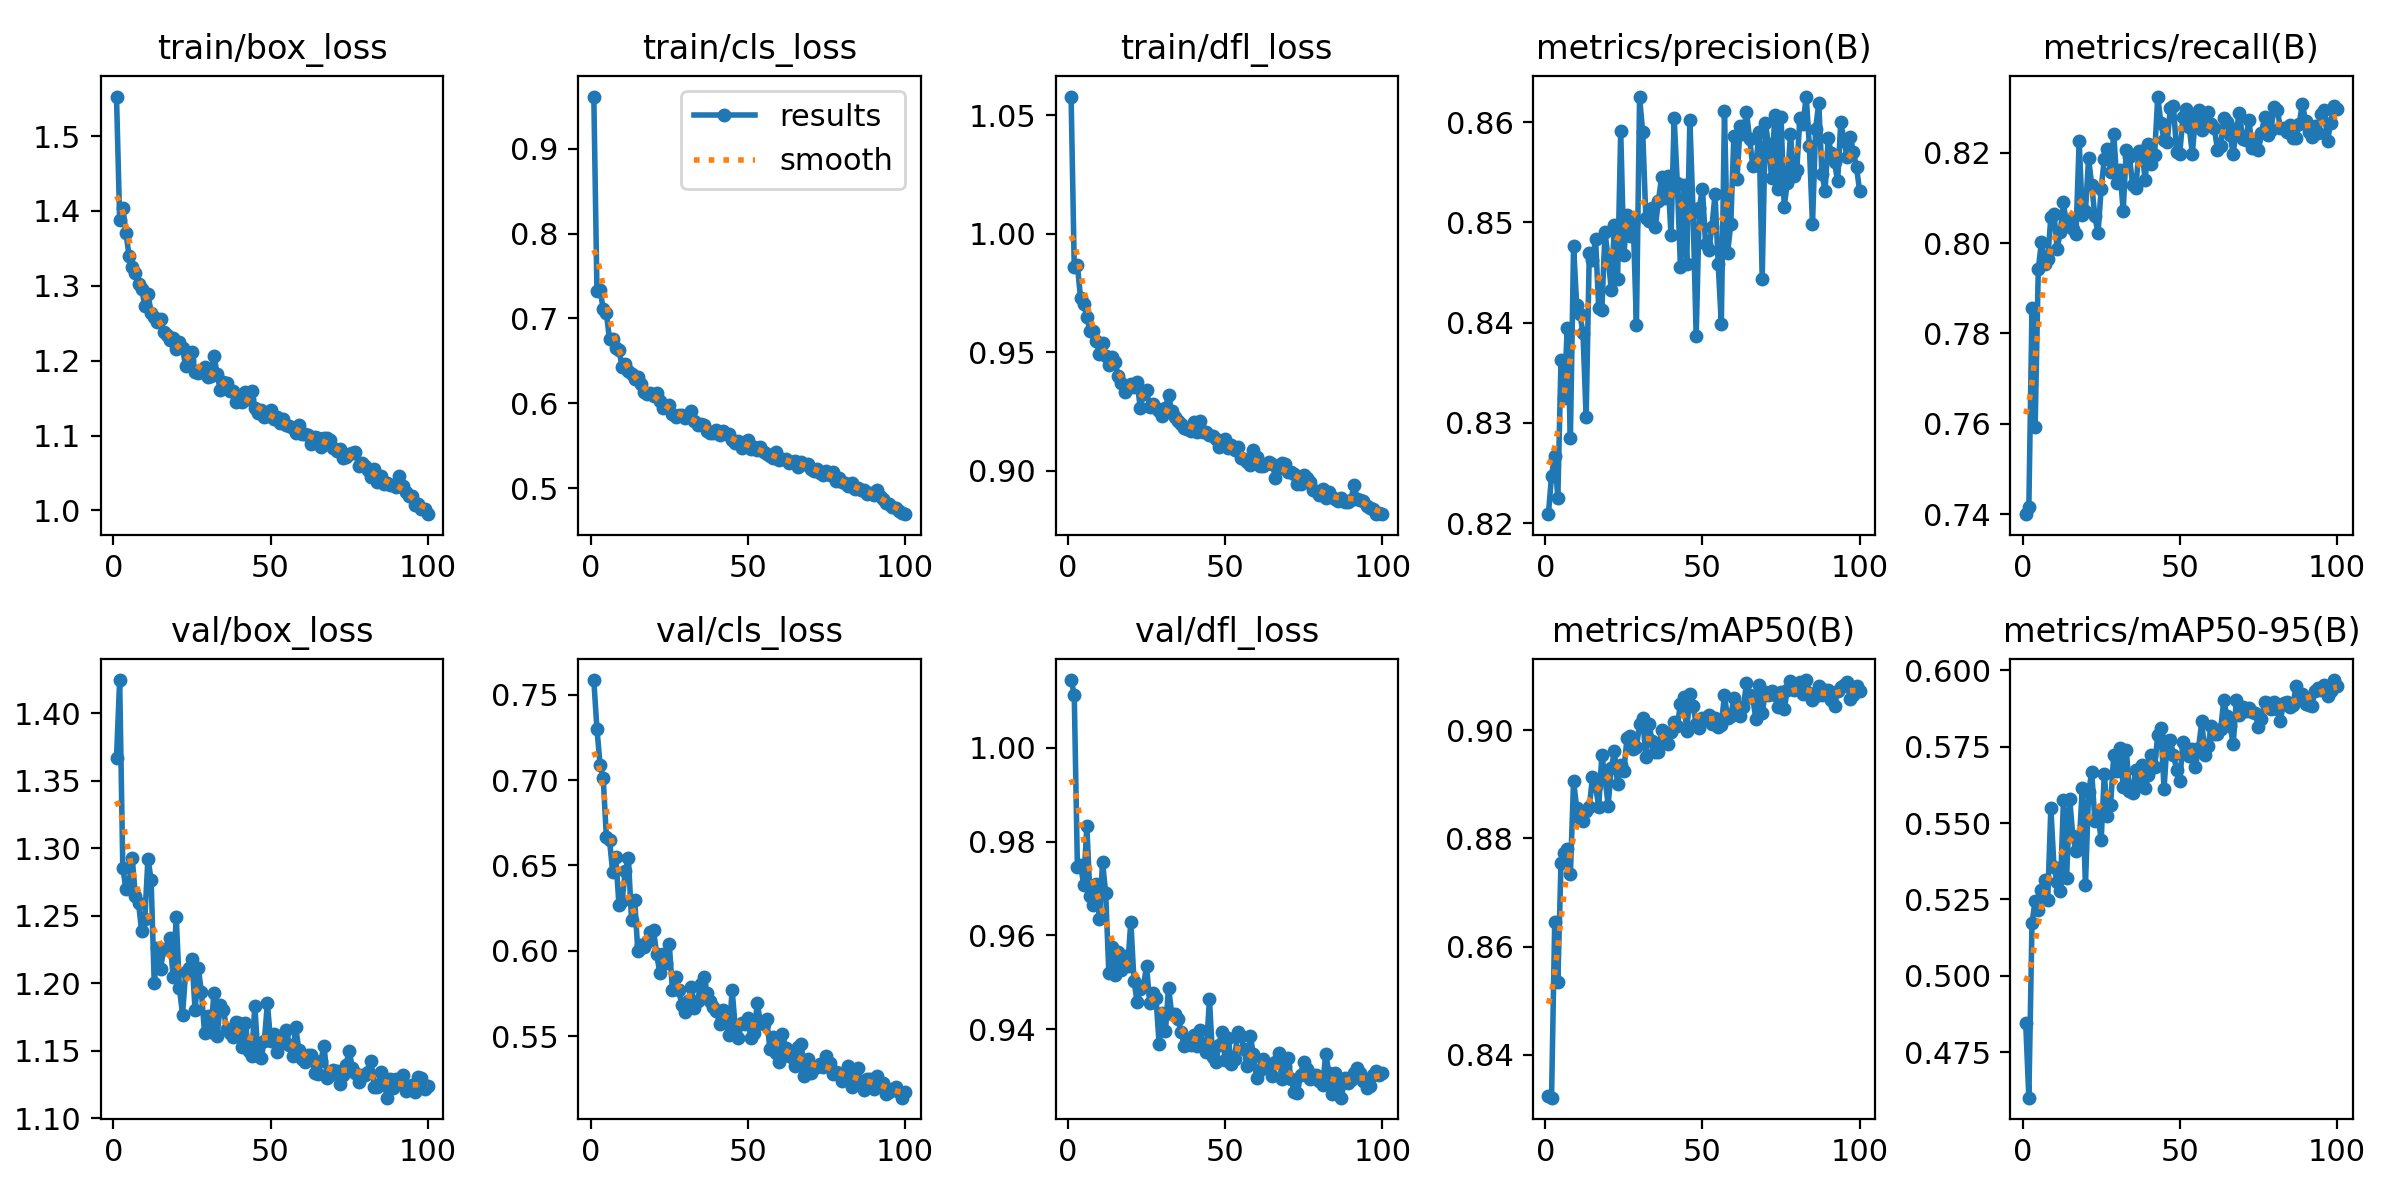

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# Path to results.csv
results_path = WORK / "simclr_yolo12s" / "results.csv"

# Load CSV
df = pd.read_csv(results_path)

# Show available columns
print("Available columns:", df.columns.tolist())

# Plot Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(df["epoch"], df["train/box_loss"], label="Train Box Loss", linewidth=2)
plt.plot(df["epoch"], df["train/cls_loss"], label="Train Class Loss", linewidth=2)
plt.plot(df["epoch"], df["val/box_loss"], label="Val Box Loss", linestyle="--")
plt.plot(df["epoch"], df["val/cls_loss"], label="Val Class Loss", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

lr_columns = [col for col in df.columns if col.startswith("lr/pg")]
colors = ['purple', 'orange', 'green']
styles = ['-', '--', '-.']
markers = ['o', 's', '^']

if lr_columns:
    plt.figure(figsize=(8, 5))
    for idx, col in enumerate(lr_columns):
        plt.plot(
            df["epoch"], df[col],
            label=col,
            color=colors[idx % len(colors)],
            linestyle=styles[idx % len(styles)],
            marker=markers[idx % len(markers)],
            markersize=4,
            linewidth=2
        )
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    plt.title("Learning Rates Over Epochs (pg0, pg1, pg2)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No learning rate columns found.")


# Plot mAP Curve (0.5 IoU)
map_keys = ["metrics/mAP50(B)", "metrics/mAP50-95(B)"]  # version dependent
map_column = next((key for key in map_keys if key in df.columns), None)

if map_column:
    plt.figure(figsize=(6, 4))
    plt.plot(df["epoch"], df[map_column], label=map_column, color="green", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("mAP")
    plt.title("mAP During Training")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("mAP column not found. Skipping mAP plot.")



from PIL import Image
from IPython.display import display

results_img = WORK / "simclr_yolo12s" / "results.png"
img = Image.open(results_img)
display(img)


 Evaluating …
Ultralytics 8.3.223 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 159 layers, 9,232,041 parameters, 0 gradients
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3715.5±1297.1 MB/s, size: 539.2 KB)
val: Scanning /kaggle/working/SSL-simclr/valid/labels.cache... 165 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 165/165 321.6Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 42/42 4.6it/s 9.2s
                   all        165      13823      0.856       0.83      0.908      0.599
    Backside-Sunflower        165      13823      0.856       0.83      0.908      0.599
Speed: 1.0ms preprocess, 43.7ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to /kaggle/working/runs/detect/val

Validation metrics
Precision (mP)   : 0.8561
Recall (mR)      : 0.8299
mAP@0.50         : 0.9082
mAP@0.50:0.95    : 0.5986
Visualising: MVI_9977-MP4_frame16_jpg.rf

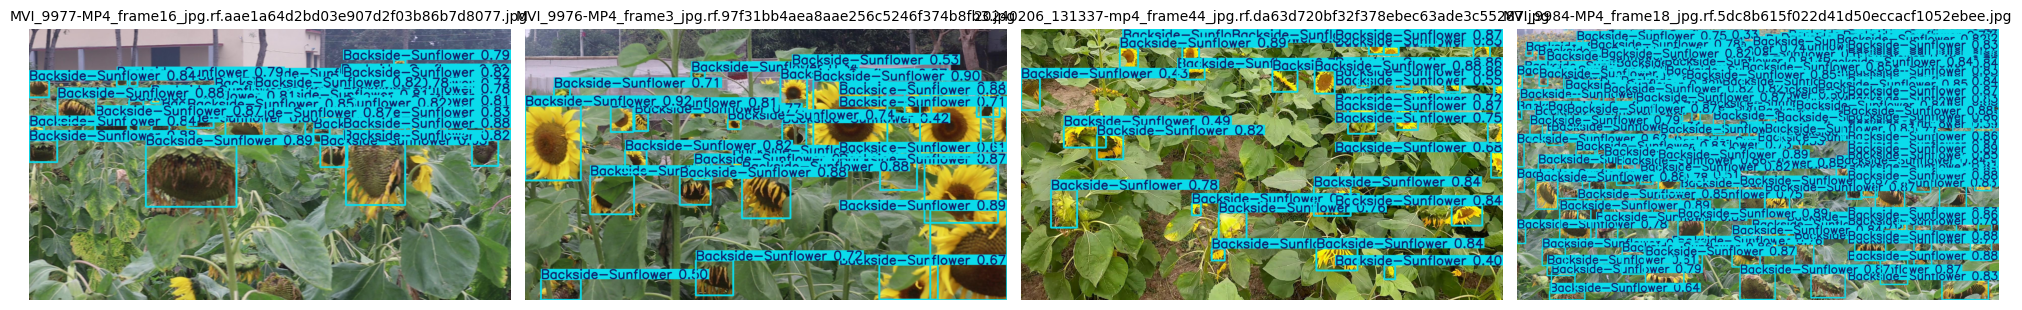

In [14]:
print("\n Evaluating …")
best_pt = WORK / "simclr_yolo12s"/"weights"/"best.pt"
model   = YOLO(str(best_pt))
results = model.val(data=str(DATA), imgsz=640, batch=4, device=0 if device=="cuda" else None)

try:
    mp,mr,map50,map5095 = results.mean_results()
    print("\nValidation metrics")
    print(f"Precision (mP)   : {mp:.4f}")
    print(f"Recall (mR)      : {mr:.4f}")
    print(f"mAP@0.50         : {map50:.4f}")
    print(f"mAP@0.50:0.95    : {map5095:.4f}")
except Exception:
    print("Ultralytics API changed; raw results follows:")
    print(results)

import random

# pick from test or valid images
cands = list((WORK/"test"/"images").glob("*.*")) or list((WORK/"valid"/"images").glob("*.*"))

if cands:
    imgs = random.sample(cands, min(4, len(cands)))  # pick up to 4 random images
    fig, axes = plt.subplots(1, 4, figsize=(20, 6))
    axes = axes.flatten()

    for ax, img_path in zip(axes, imgs):
        print("Visualising:", img_path.name)
        pred = model.predict(
            source=str(img_path),
            imgsz=640,
            conf=0.25,
            device=0 if device == "cuda" else None,
            verbose=False
        )[0]
        ax.imshow(pred.plot()[:,:,::-1])
        ax.axis("off")
        ax.set_title(img_path.name, fontsize=10)

    # hide unused axes if <4 images
    for ax in axes[len(imgs):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

else:
    print("No images found for visualization.")